<a href="https://colab.research.google.com/github/SrivenkateswaraRao/Research-Project/blob/master/Pest_Classifier_GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output


In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)


In [ ]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)


In [ ]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')


In [ ]:
model.summary()


Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_8[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

In [ ]:
epochs = 25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])


In [ ]:
import os
from os import listdir
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_list = drive.ListFile(
    {'q': "'1MzurTS9xeNSss_hYgko4ATZ5qNVn45ty' in parents"}).GetList()

for f in file_list:
    print('title: %s, id: %s' % (f['title'], f['id']))
    fname = f['title']
    print('downloading to {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)

title: LABELS.zip, id: 1dYxm-yV2sCOxiQQSvzRY6-gKtlfo0WLH
downloading to LABELS.zip
title: GREENPATROL_DB_V1.0.zip, id: 1wJw1Ci1OTUoKjiiT3lwWqwonTunGPMB1
downloading to GREENPATROL_DB_V1.0.zip
title: predefined_classes.txt, id: 1XQkqHvepaPEXxJ5XXSZmMMk9qrxTOSzJ
downloading to predefined_classes.txt


In [ ]:
#------------------------------- Load Train Data ----------------------------------------------#
download_Pests = drive.CreateFile({'id': '1wJw1Ci1OTUoKjiiT3lwWqwonTunGPMB1'})
download_Annotations = drive.CreateFile({'id': '1dYxm-yV2sCOxiQQSvzRY6-gKtlfo0WLH'})
!unzip LABELS.zip -d '/Tomato-Pests'
!unzip GREENPATROL_DB_V1.0.zip -d '/Tomato-Pests'


Archive:  LABELS.zip
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-102849.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-102918.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110731.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110804.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110827.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110905.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-110931.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-111004.xml  
  inflating: /Tomato-Pests/LABELS/1_2_2_6_1_1_20180622-111118.xml  
Archive:  GREENPATROL_DB_V1.0.zip
  inflating: /Tomato-Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-102849.jpg  
  inflating: /Tomato-Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-102918.jpg  
  inflating: /Tomato-Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-110731.jpg  
  inflating: /Tomato-Pests/GREENPATROL_DB_V1.0/1_2_2_6_1_1_20180622-110804.jpg  
  inflati

In [ ]:
from google.colab import files
files.upload() 

Saving CreatePestImageData_GoogleNet.py to CreatePestImageData_GoogleNet.py


{'CreatePestImageData_GoogleNet.py': b'# -*- coding: utf-8 -*-\r\n"""createImageDataset.ipynb\r\n\r\nAutomatically generated by Colaboratory.\r\n\r\nOriginal file is located at\r\n    https://colab.research.google.com/drive/1FXiYKCQ-jtbL_O29BQb2Xy1bBd2inM9q\r\n"""\r\n\r\nfrom os import listdir\r\nimport numpy as np\r\nimport xml.etree.ElementTree as ET\r\nimport cv2\r\nimport tensorflow as tf \r\n\r\nclass createImageDataset(object):\r\n    \r\n    def __init__(self, class_map=None):\r\n        self.image_info = []\r\n        self.trainX = []\r\n        self.trainY = []\r\n        self.testX = []\r\n        self.testY = []\r\n            \r\n    def add_image_info(self , image_array , image_path , image_id , object_id , class_name , class_id):\r\n        \r\n        image_info_ = {\'object_id\': image_id,\r\n                       \'object_class\': class_name,\r\n                       \'image_path\': image_path,\r\n                       \'image_array\': image_array,\r\n              

In [ ]:
import CreatePestImageData_GoogleNet as Imagedataset

In [ ]:
dataSet = Imagedataset.createImageDataset()

In [ ]:
class_object = {0 : 'egg_wf' ,
                1 : 'egg_bt', 2 : 'egg_ta', 3 : 'wf', 4 : 'bt', 5 : 'ta', 6 : 'ta_maps', 7 : 'ta_larvae', 8 : 'ta_maps+larvae', 9 : 'tomato'}

In [ ]:
 dataSet.prepare_dataset('/Tomato-Pests/LABELS/' , class_object , '/Tomato-Pests/GREENPATROL_DB_V1.0/',  test_size=5 )

In [ ]:
(trainY , trainX) , (testY , testX ) = (dataSet.trainY , dataSet.trainX ) , (dataSet.testY , dataSet.testX )


In [ ]:
history = model.fit(trainX, [trainY, trainY, trainY], validation_data=(testX, [testY, testY, testY]), epochs=epochs, batch_size=256, callbacks=[lr_sc])


Train on 67 samples, validate on 5 samples
Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
67/67 [==============================] - 15s 220ms/step - loss: 6.7824 - output_loss: 2.5714 - auxilliary_output_1_loss: 9.2897 - auxilliary_output_2_loss: 4.7471 - output_accuracy: 0.1045 - auxilliary_output_1_accuracy: 0.0896 - auxilliary_output_2_accuracy: 0.0448 - val_loss: 15.5496 - val_output_loss: 9.5369 - val_auxilliary_output_1_loss: 16.5786 - val_auxilliary_output_2_loss: 3.4640 - val_output_accuracy: 0.6000 - val_auxilliary_output_1_accuracy: 0.6000 - val_auxilliary_output_2_accuracy: 0.6000
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
67/67 [==============================] - 13s 197ms/step - loss: 6.1630 - output_loss: 3.8999 - auxilliary_output_1_loss: 6.0687 - auxilliary_output_2_loss: 1.4749 - output_accuracy: 0.8358 - auxilliary_output_1_accuracy: 0.8358 - auxilliary_output_2_accuracy: 0.8060 - val_loss: 3.6210 - val_o

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(67, 224, 224, 3)
(67,)
(5, 224, 224, 3)
(5,)


In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
   
  plt.imshow(img[...,0], cmap=plt.cm.binary)
 
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
   
  plt.xlabel("{} {:2.0f}% ({})".format(class_object[predicted_label],
                                100*np.max(predictions_array),
                                class_object[true_label]),
                                color=color)


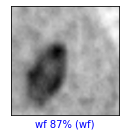

In [ ]:
num_rows = 1
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
test_images = testX[:num_images]
predictions = model.predict(testX)
for i in range(num_images):    
    plt.subplot(num_rows, num_cols, i+1)   
    plot_image(i, predictions, testY, testX)    
 
plt.tight_layout()
plt.show()